# TP2 Vision por computadora I

## Abraham Rodriguez

In [1]:
#%matplotlib 
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd


## Utilities

In [2]:
def open_images(path : str, color_scale = cv.COLOR_BGR2RGB) -> list:
    """
    Opens all images from a directory.
    Args:
        path: str -> file path of the directory
    Returns:
        list -> list of image matrices. 
    """
    import os 
    temp = []
    if path.endswith("/"):
        items = os.listdir(path)
    
        for p in items:
            
            if (p.endswith("png") | p.endswith("pg")):

                img = cv.cvtColor(cv.imread(path + p), color_scale)
                temp.append(img)
        return temp
    if color_scale is cv.IMREAD_GRAYSCALE:
        return cv.imread(path, color_scale)
    return cv.cvtColor(cv.imread(path), color_scale)

def show_image_list(images : list, nrows = 1, figsize = (12,8), cmap :list = ['gray'], titles = [""]):
    ncols = len(images)
    _, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)

    axes = axes.ravel()

    for i in range(len(axes)):
       axes[i].set_axis_off()
       if (len(cmap)>1):
           axes[i].imshow(images[i], cmap=cmap[i])
           if (len(titles)>0):
               axes[i].set_title(titles[i])
       else:
           axes[i].imshow(images[i], cmap=cmap[0])
           if (len(titles)>0):
               axes[i].set_title(titles[i])

def show_plots(plots, nrows = 1,figsize=(12,8)):
    ncols = len(plots)
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)

    axes = axes.ravel()

    for i in range(len(axes)):
       axes[i].plot(plots[i])

kernel = ksize * ksize
agregar un padding de ceros al kernel
aplicar la transformada de fourier al kernel
multiplicar por la transformada de fourier de la imagen

In [3]:
def create_gauss_filter_3(h : int ,w: int ,k_size: int,sigma: float):
    """
    Creates a gaussian filter and it's fourier transform 
    with size H x W that corresponds to a target image
    """
    #img = np.zeros((k_size ,k_size ))
    # img[(k_size )//2, ( k_size )//2]= 1
    
    h_1, w_1 = (k_size,k_size)

    a = (h - h_1) // 2
    aa = h - a - h_1

    b = (w - w_1) // 2
    bb = w - b - w_1

    #img = np.pad(img,  pad_width=((a, aa), (b, bb)), mode='constant')
    #const = (1/(2*np.pi * sigma**2))
    #kernel = np.fromfunction(lambda x, y : ((1/(2*np.pi*(sigma**2))) * np.exp(-((((x-(k_size+1))**2) +(y-(k_size+1))**2)/(2*sigma**2)))), (k_size, k_size))
    #filter = cv.GaussianBlur(img,(k_size, k_size), sigma)
    k = cv.getGaussianKernel(k_size,sigma) 
    ker = k @ k.T
    ker /= ker.sum()
    img = np.pad(ker,  pad_width=((a, aa), (b, bb)), mode='constant')
    gaussian_filter = img/np.sum(img)
    return gaussian_filter, np.fft.fft2(gaussian_filter)

In [4]:
def show_gauss_fft_filter(kernel,kernel_fft,k_size,sigma, img_gauss):
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title(f"Kernel Gausiano k = {k_size} sigma = {sigma}",fontsize=6)
    plt.imshow(kernel, cmap='jet')
    
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title(f"FFT del kernel  k = {k_size} sigma = {sigma}",fontsize=6)
    tf_shifted = np.fft.fftshift(kernel_fft)
    plt.imshow(np.abs(tf_shifted), cmap='jet')

    plt.subplot(1,3,3)
    plt.axis('off')
    plt.imshow(img_gauss, cmap='gray')
    plt.title('Desenfoque gausiano',fontsize=6)
    plt.tight_layout()

In [5]:
def apply_gaussian_filter(img,kernel_fft):
    img_fft = np.fft.fft2(img)
    filtered = img_fft * kernel_fft
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
    return img_gauss

In [7]:
pred_img = open_images("../TP1/fft_alfa_pred.png",color_scale=cv.IMREAD_GRAYSCALE)
h, w = pred_img.shape

In [8]:
kernel, kernel_fft = create_gauss_filter_3(h,w,3,1)

C:\Users\a\AppData\Local\Temp\ipykernel_19320\3326560679.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,4))


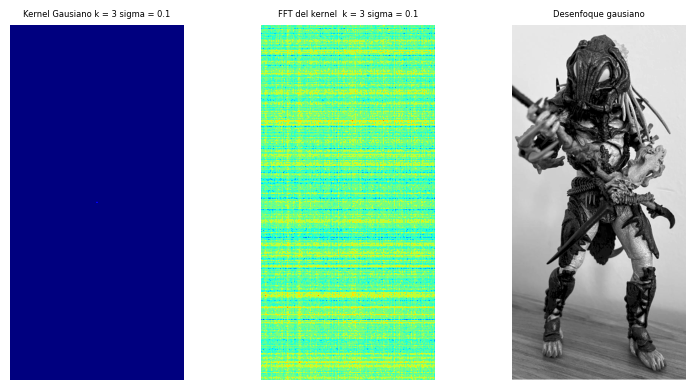

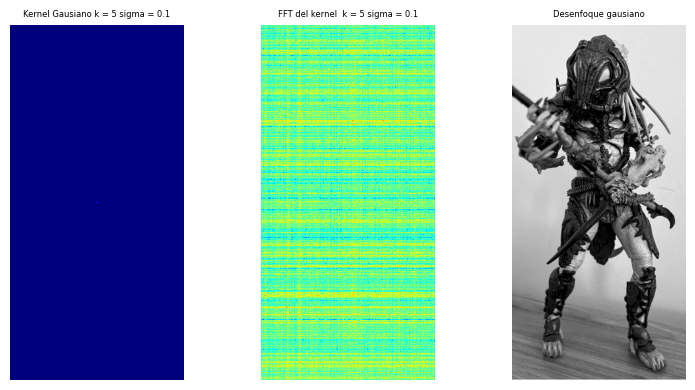

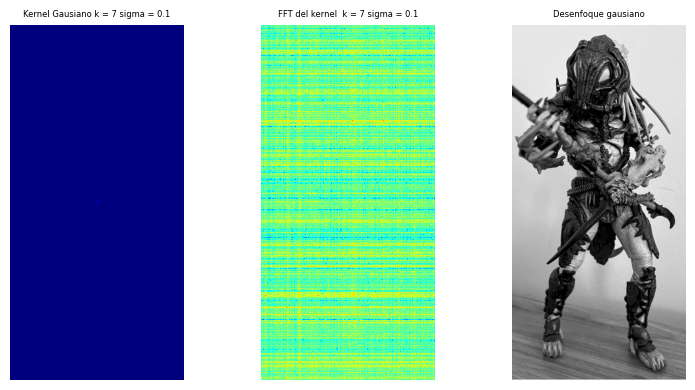

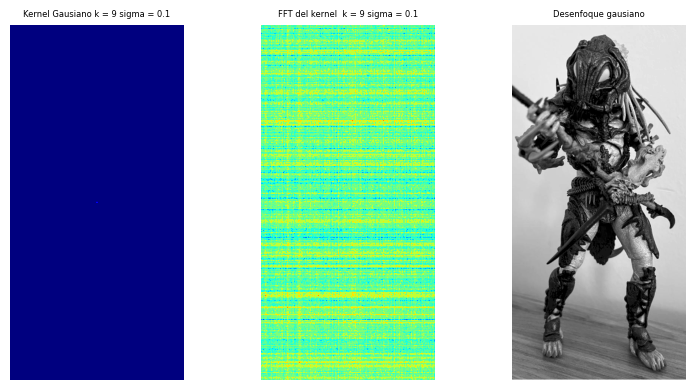

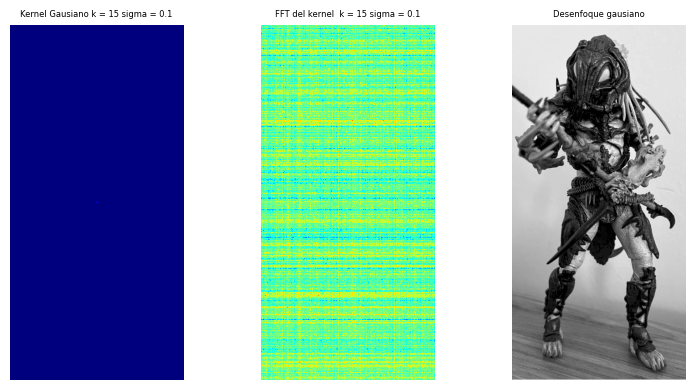

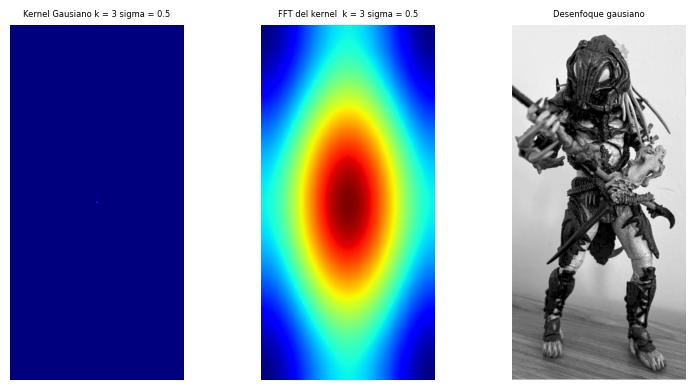

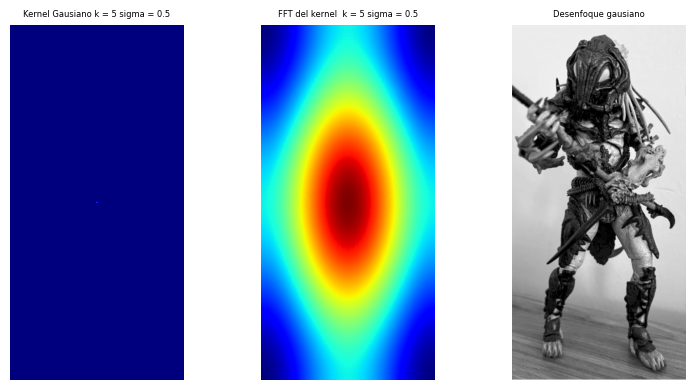

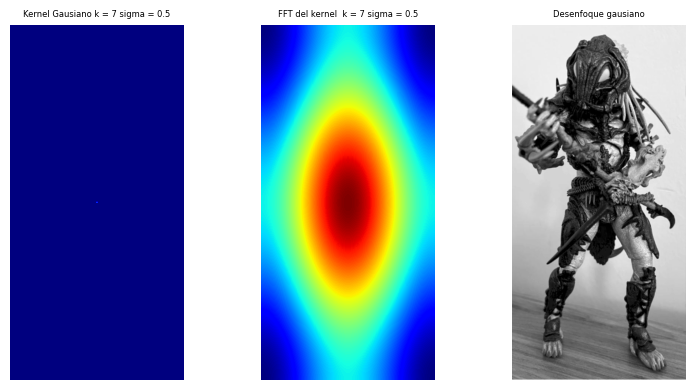

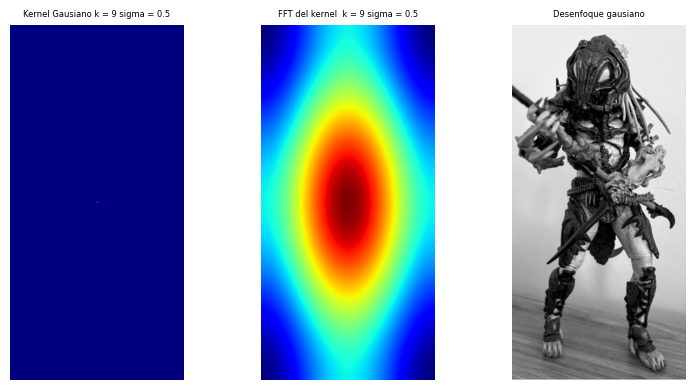

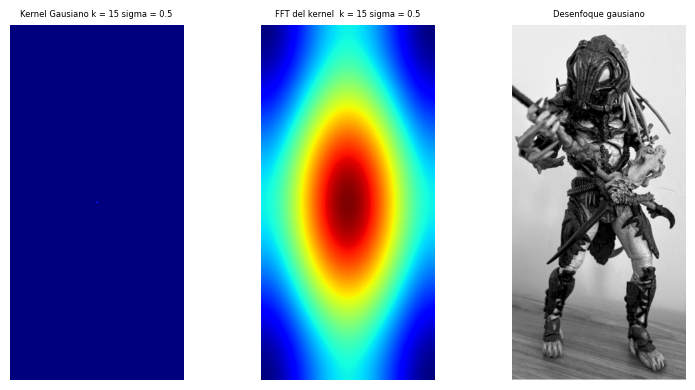

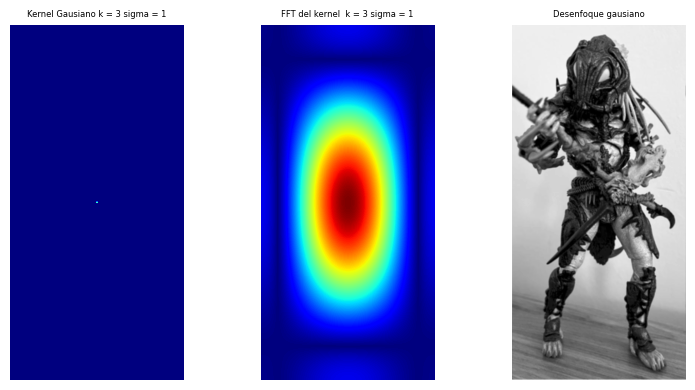

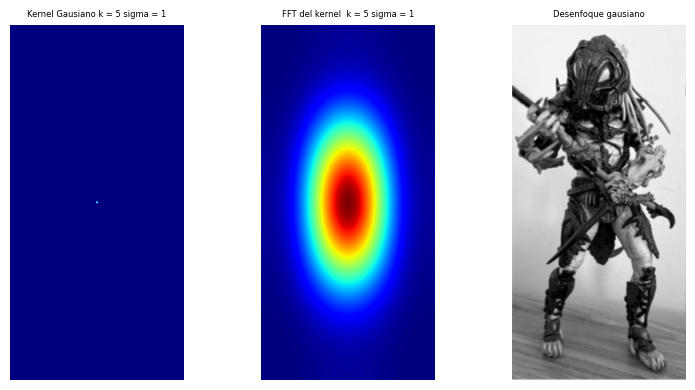

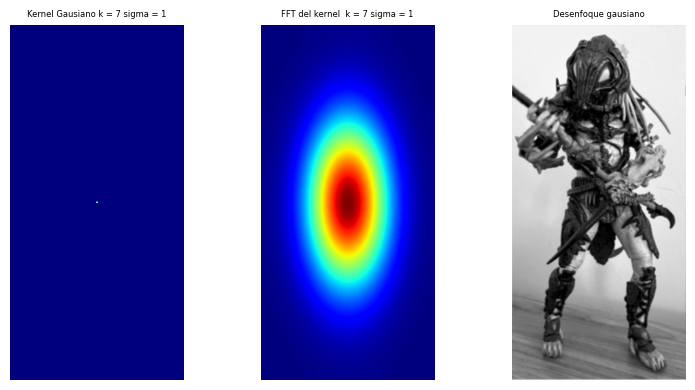

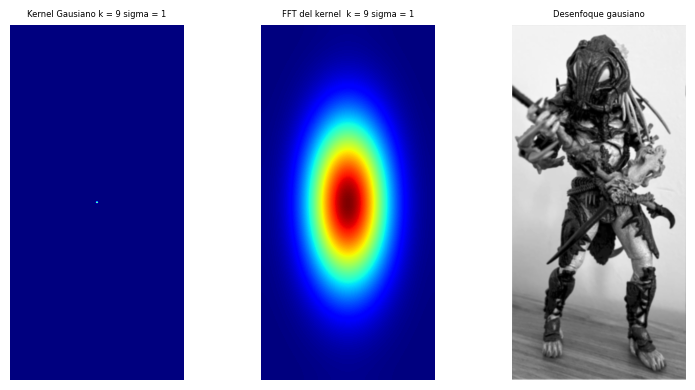

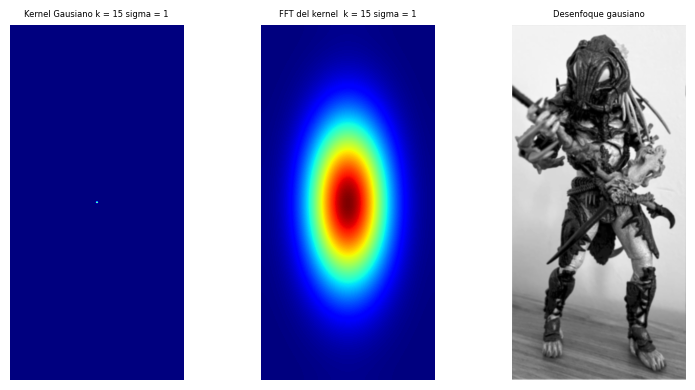

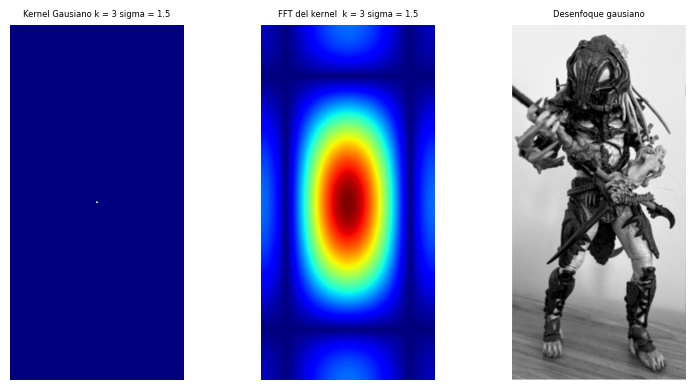

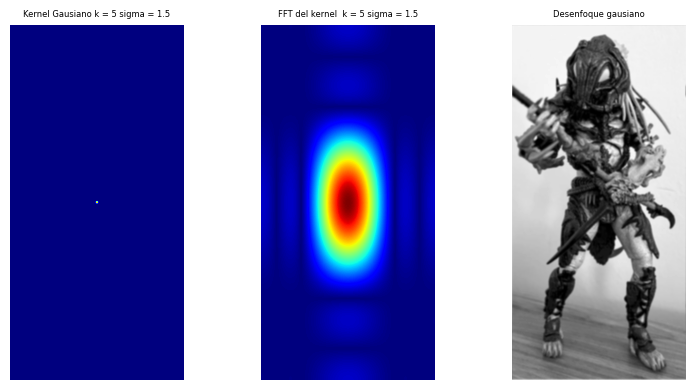

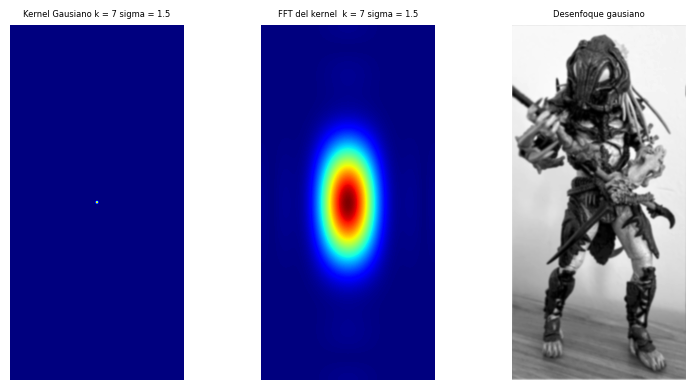

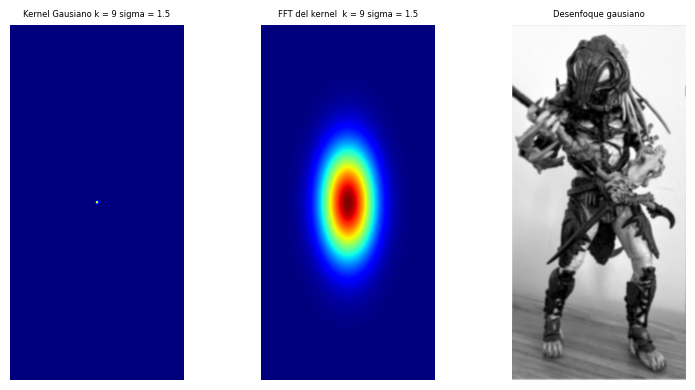

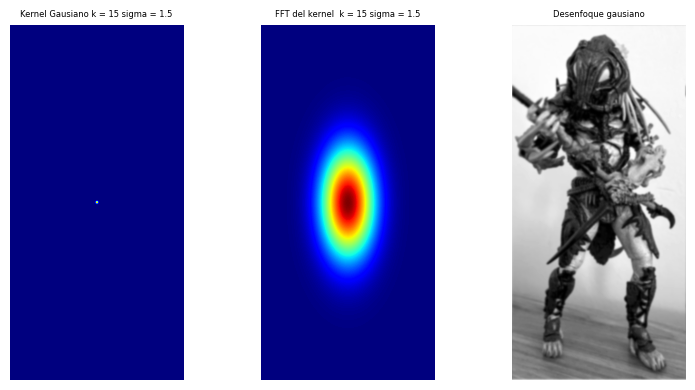

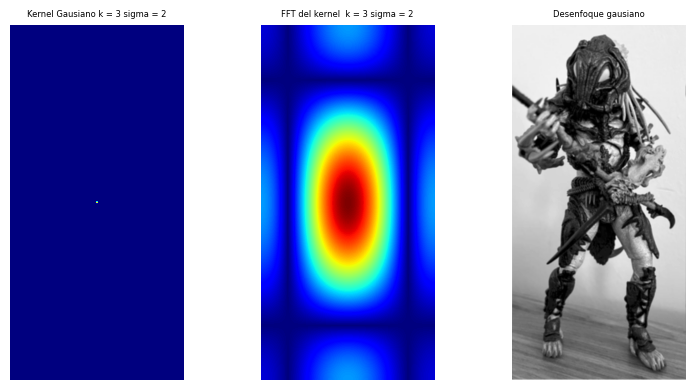

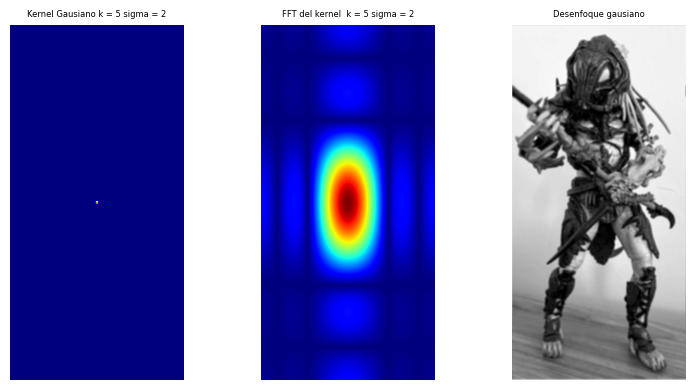

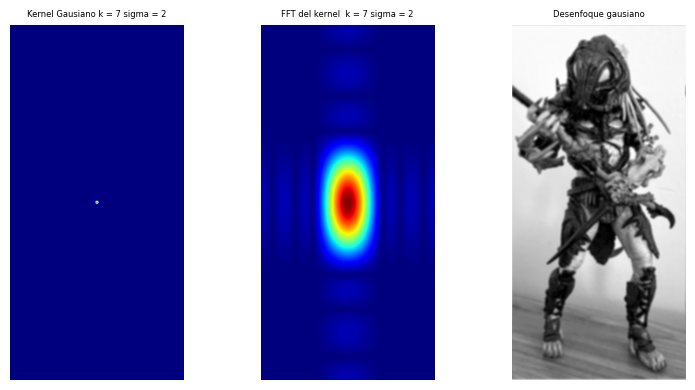

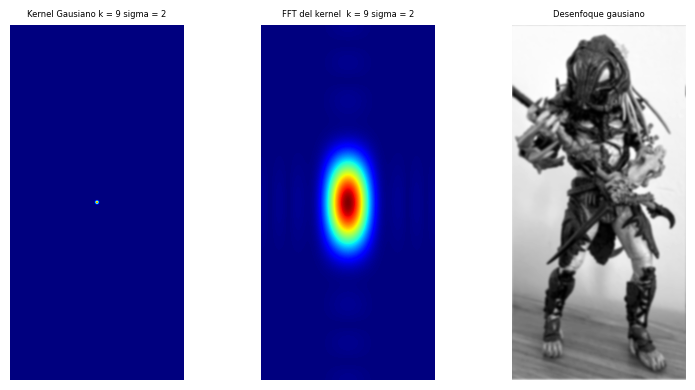

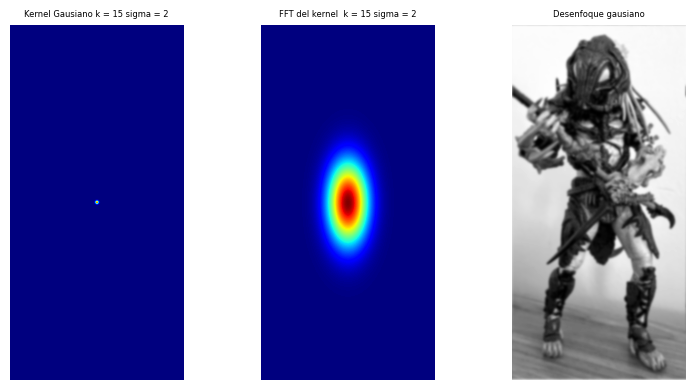

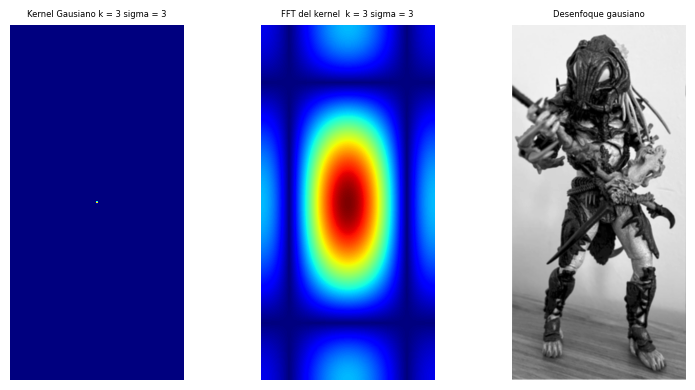

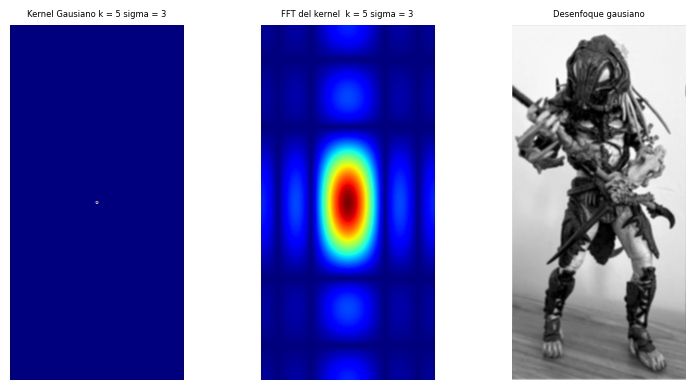

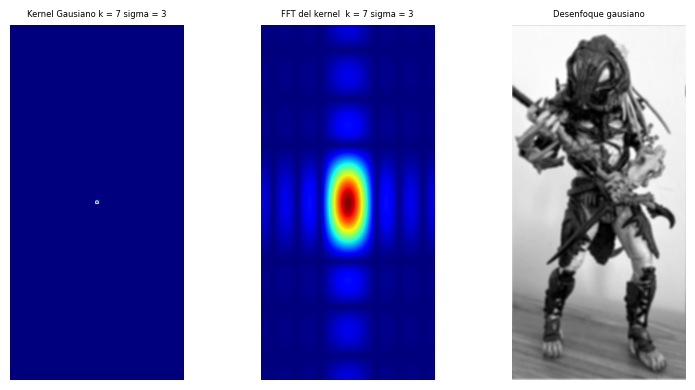

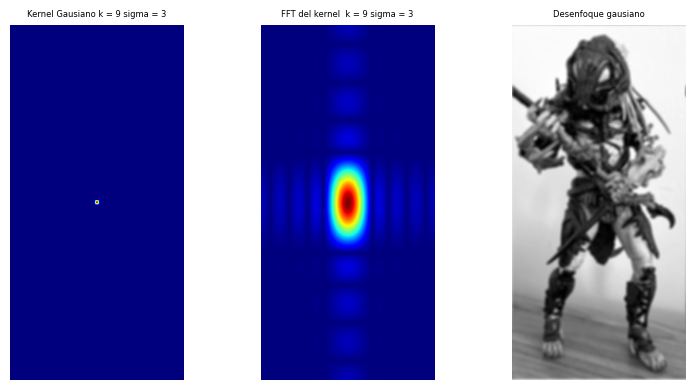

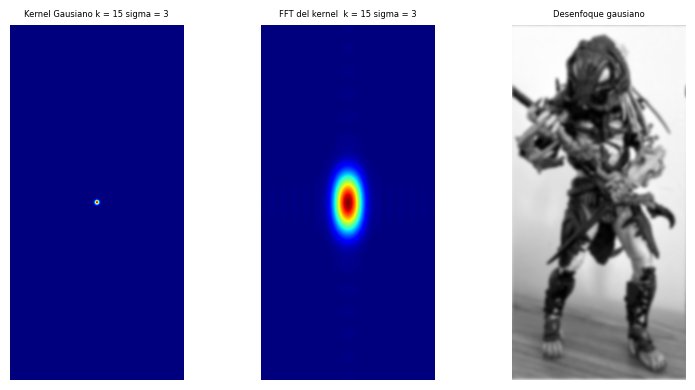

In [9]:
temp = []
tests = {"k":[3,5,7,9,15],"sigma":[0.1,0.5,1,1.5,2,3]}
for sigma in tests['sigma']:
    for k_size in tests['k']:
        kernel, kernel_fft = create_gauss_filter_3(h,w,k_size,sigma)
        img_blur = apply_gaussian_filter(pred_img,kernel_fft)
        show_gauss_fft_filter(kernel,kernel_fft,k_size,sigma,img_blur)

### PARTE II

Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency 
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral

In [10]:
def img_quality_measure(img):
    fft = np.fft.fft2(img)
    fft = np.fft.fftshift(fft)
    abs_fft = np.abs(fft)
    max_fft = np.max(abs_fft)

    t_h = fft > max_fft/1000
    return (t_h/max_fft* img.shape[1])

In [12]:
img = open_images("../TP1/coord_cromaticas/CoordCrom_1.png", color_scale=cv.IMREAD_GRAYSCALE)
h, w = img.shape

### calidad original

In [13]:
img_quality_measure(img).sum()

0.0054132614180499436

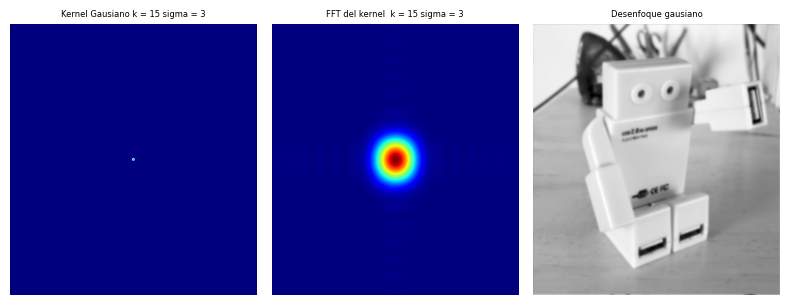

In [14]:
kernel, kernel_fft = create_gauss_filter_3(h,w,15,3)
img_blur = apply_gaussian_filter(img,kernel_fft)
show_gauss_fft_filter(kernel,kernel_fft,15,3,img_blur)

### calidad despues del desenfoque gaussiano

In [15]:
img_quality_measure(img_blur).sum()

0.004649772524405908

## Comparando el metodo por convolucion vs filtrado espectral

In [16]:
img_blur_cv = cv.GaussianBlur(img,(15,15),3)

In [17]:
img_quality_measure(img_blur_cv).sum()

0.00454965550169488

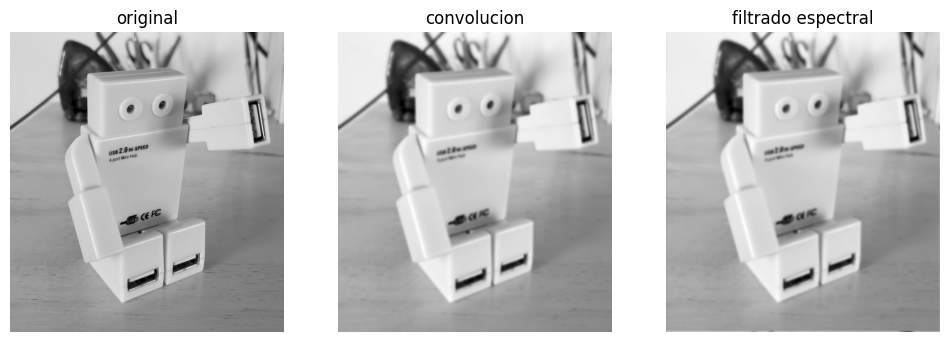

In [18]:
show_image_list([img,img_blur_cv,img_blur],titles=["original","convolucion","filtrado espectral"])

El resultado muestra que ambos filtrados reducen la calidad de la imagen, sin embargo la calidad por convolucion es un poco menor al filtrado espectral, esto a simple vista es imperceptible

## PARTE III

Se implmentan 3 metodos del paper "Analysis of focus measure in shape from focus" 
y se comparan, de nuevo los resultados de convolucion vs filtrado espectral, debido a que en la parte II se obtiene que convolucion tiene una metrica un poco mayor a espectral se espera obtener resultados similares.

In [19]:
def energy_of_laplacian(img):
    laplacian = cv.Laplacian(img**2,-1,cv.CV_16S,ksize=3)
    return np.abs(np.sum(laplacian))


In [20]:
def modified_DCT(img):
    mask = np.array([
        [1,1,-1,-1],
        [1,1,-1,-1],
        [-1,-1,1,1],
        [-1,-1,1,1]
    ])
    phi = cv.filter2D(img,-1,mask)
    return phi

In [21]:
def eigenvalue_measure(img):
    normed =  img - np.mean(img)
    cov = (normed@normed.T)/((img.shape[0]*img.shape[1]) - 1)

    eigval,_=  np.linalg.eig(cov)
    phi = np.sum(eigval)
    return np.linalg.norm(phi)


In [22]:
def gray_level_variance(img):
    mu = np.mean(img)
    phi = np.sum((img-mu)**2)
    return phi

In [23]:
def apply_metrics(images : list):
    df = pd.DataFrame(columns=['dct','eigenvalues','gray_level_variance'])
    for img in images:
        dct = energy_of_laplacian(img).sum()
        eigen = eigenvalue_measure(img)
        gray_lvl = gray_level_variance(img)
        #pd.concat([[dct,eigen,gray_lvl],metrics])
        data = pd.DataFrame([{"dct":dct,"eigenvalues":eigen,"gray_level_variance":gray_lvl}])
        df = pd.concat([df,data])
    return df
    


In [24]:
df = apply_metrics([img,img_blur_cv,img_blur])
df['image'] = ['original', 'convolution', 'spectral']

Para cada imagen, se aplican las metricas y se puede ver en la tabla inferior, que las metricas del filtrado 
espectral son inferiores a las del filtrado por convolucion, mismo resultado que en la Parte II.

In [25]:
df

dct  eigenvalues  gray_level_variance        image
0        93141453  1690.910197         1.529203e+09     original
0        55793438  1541.752228         1.394310e+09  convolution
0  2041490.139446  1530.778332         1.384385e+09     spectral